In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np

# Custom function for displaying the shape and head of a dataframe
def display(df, n=5):
    print(df.shape)
    return df.head(n)

In [3]:
# Full dataset from NOAA
df1 = pd.read_csv('../data_input/6_NOAA_sea_level/sea_level.csv')
display(df1)

(35046, 20)


,Site,PSMSL ID,Latitude,Longitude,Scenario,Background RSL rate (mm/yr),RSL in 2000 (cm),RSL in 2010 (cm),RSL in 2020 (cm),RSL in 2030 (cm),RSL in 2040 (cm),RSL in 2050 (cm),RSL in 2060 (cm),RSL in 2070 (cm),RSL in 2080 (cm),RSL in 2090 (cm),RSL in 2100 (cm),RSL in 2120 (cm),RSL in 2150 (cm),RSL in 2200 (cm)
0,GMSL,0,NaN,NaN,0.3 - MED,0.0,0,3,6,9,13,16,19,22,25,28,30,34.0,37.0,39.0
1,GMSL,0,NaN,NaN,0.3 - LOW,0.0,0,3,5,9,12,15,18,21,24,26,29,30.0,32.0,29.0
2,GMSL,0,NaN,NaN,0.3 - HIGH,0.0,0,3,6,10,13,17,20,23,26,28,31,42.0,51.0,67.0
3,GMSL,0,NaN,NaN,0.5 - MED,0.0,0,4,8,13,18,24,29,35,40,45,50,60.0,73.0,95.0
4,GMSL,0,NaN,NaN,0.5 - LOW,0.0,0,3,7,12,16,22,27,33,38,44,49,56.0,66.0,77.0


In [57]:
# Let's focus on the rows with grid points only
df2 = df1[df1['Site'].str.startswith('grid')].copy()

# We'll select only the Intermediate (1.5m) sea level rise scenario, and the
# MED sub-scenario within that
df2 = df2[df2['Scenario'] == '1.5 - MED']

# Drop useless columns
df2 = df2.drop(columns=['Site','PSMSL ID','Scenario','Background RSL rate (mm/yr)','RSL in 2000 (cm)'])

# Rename the others
df2.columns = ['latitude','longitude','2010',
 '2020',
 '2030',
 '2040',
 '2050',
 '2060',
 '2070',
 '2080',
 '2090',
 '2100',
 '2120',
 '2150',
 '2200']

# Reset the index
df2 = df2.reset_index()

display(df2)

(1708, 16)


,index,latitude,longitude,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100,2120,2150,2200
0,4311,71.5,-161.5,8,15,22,34,50,66,86,109,132,159,210.0,315.0,524.0
1,4329,71.5,-160.5,8,15,22,34,50,66,86,110,134,160,210.0,318.0,528.0
2,4347,71.5,-159.5,8,16,22,34,49,66,86,109,134,160,209.0,317.0,527.0
3,4365,71.5,-158.5,8,16,23,34,50,67,86,109,133,159,209.0,316.0,526.0
4,4383,71.5,-157.5,8,15,22,33,49,65,86,109,132,158,209.0,316.0,521.0


I will now generate geopandas polygon bounding boxes for each of the grid points.  The current lat/long measurements refer to the center of a square grid box that is one degree on each side.

In [58]:
import geopandas as gpd
from shapely.geometry import Polygon


def make_geom(x):
    return Polygon([(x['longitude']+0.5, x['latitude']+0.5), 
                 (x['longitude']+0.5, x['latitude']-0.5), 
                 (x['longitude']-0.5, x['latitude']-0.5), 
                 (x['longitude']-0.5, x['latitude']+0.5)])

geometry_list = df2.apply(make_geom, axis=1)

# Generate a geopandas dataframe from the previous dataframe and this new geometry.
df3 = geopandas.GeoDataFrame(df2, geometry=geometry_list)

# Drop a couple of useless columns
df3 = df3.drop(columns=['index','latitude','longitude'])

display(df3)

(1708, 14)


,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100,2120,2150,2200,geometry
0,8,15,22,34,50,66,86,109,132,159,210.0,315.0,524.0,"POLYGON ((-161 72, -161 71, -162 71, -162 72, ..."
1,8,15,22,34,50,66,86,110,134,160,210.0,318.0,528.0,"POLYGON ((-160 72, -160 71, -161 71, -161 72, ..."
2,8,16,22,34,49,66,86,109,134,160,209.0,317.0,527.0,"POLYGON ((-159 72, -159 71, -160 71, -160 72, ..."
3,8,16,23,34,50,67,86,109,133,159,209.0,316.0,526.0,"POLYGON ((-158 72, -158 71, -159 71, -159 72, ..."
4,8,15,22,33,49,65,86,109,132,158,209.0,316.0,521.0,"POLYGON ((-157 72, -157 71, -158 71, -158 72, ..."


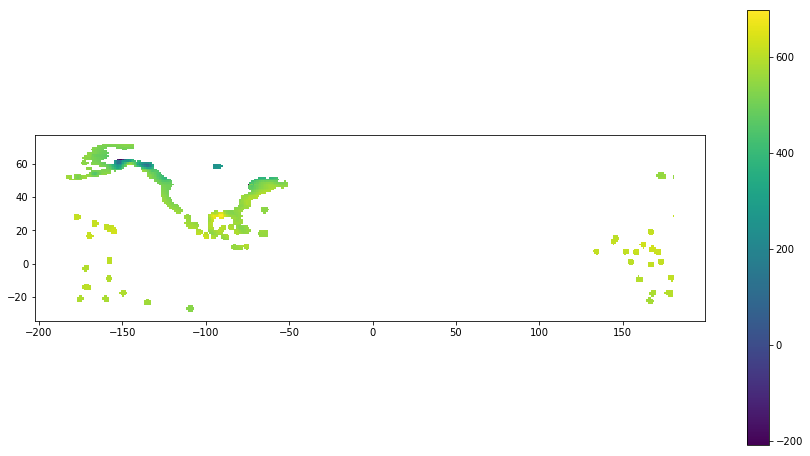

In [60]:
df3.plot(column='2200', figsize=(15,8), legend=True);

In [61]:
# Write to geojson file
df3.to_file("../data_output/7__sea_level/sea_level.geojson",
                     driver='GeoJSON')